# Example: Generate custom vessel graphs

This jupyter notebook shows how you can generate new synthetic vessel maps using the python scripts, instead of the docker version. We show an example where we adjust the parameters to facilitate the simulation of 12x12 mm² macular OCTA images.

## Prerequisites:
A clean [conda](https://docs.conda.io/en/main/miniconda.html) environment with python 3 (tested with python 3.11)

In [ ]:
!pip install -r requirements.txt

In [1]:
# Import libraries for this notebook
from matplotlib import pyplot as plt
import yaml
from glob import glob
from natsort import natsorted
from PIL import Image

## 1. Visualize the default settings (Optional)

In [6]:
# The default vessel graphs in CSV format
SOURCE_DIR="./datasets/vessel_graphs"
# The foulder we will save the visualized images
OUT_DIR="./results/visualize_3x3/"
# The desired resolution. The graphs were create in a 1x1x1/76 simulation space. Multiply each dimension with the same factor.
RESOLUTION="304,304,4"
# Number of samples to visualize. We will only generate one sample for this test
NUM_SAMPLES=1

!python ./visualize_vessel_graphs.py --source_dir $SOURCE_DIR --out_dir $OUT_DIR --resolution $RESOLUTION --num_samples $NUM_SAMPLES

Your provided volume dimensions are [304 304   4]. Make sure to use the same size relations as used for generating the graph.
Rendering 1 vessel graphs: ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━   0% -:--:-- 0:00:00


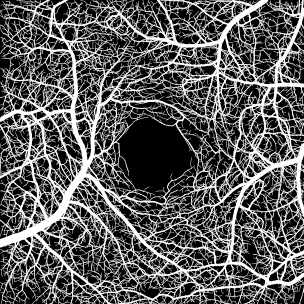

In [7]:
paths = glob(f"{OUT_DIR}/*.png")
Image.open(paths[0])

## 2. Configure vessel simulation config file

Most functionality of out simulation model can be tuned by changing the parameters of the `config.yml` file. We will create a new custom file that supports the simulation of 12x12 mm² macular OCTA images.

The parameters that we choose in the following are not optimal but can be a good start if you decide to work with wide-field OCTA data.

In [8]:
with open("./vessel_graph_generation/configs/dataset_18_June_2023.yml", "r") as stream:
    config: dict[str,dict] = yaml.safe_load(stream)

In [9]:
# We will generate a 12x12 mm² space
config["Greenhouse"]["param_scale"] = 12
# Because of the larger FOV, the optical nerve is now visible.
config["Forest"]["type"]="nerve"
# Our images will now have 1216x1216 pixel to ensure the same mm² to pixel resolution.
config["output"]["image_scale_factor"]=1216
# Z-dimension gets smaller relatively to lateral dimensions
config["Greenhouse"]["SimulationSpace"]["no_voxel_z"] = 0.0033
# We need more oxygen sinks as we now have a larger area 
config["Greenhouse"]["modes"][0]["N"]=8000
config["Greenhouse"]["modes"][1]["N"]=8000
# We need more timesteps to grow all vessels
config["Greenhouse"]["modes"][0]["I"]=400
config["Greenhouse"]["modes"][1]["I"]=500
# We slightly increase the initial vessel length to ensure that the vessels reach the entire space
config["Greenhouse"]["d"]=0.15
# We decrease the simulation space expansion to ensure that we cover the entire space
config["Greenhouse"]["modes"][0]["delta_sigma"]=0.002222
config["Greenhouse"]["modes"][1]["delta_sigma"]=0.002222
config["Forest"]["N_trees"]=16

# Output folder
config["output"]["directory"]="./datasets/my_custom_vessel_graphs_12x12"

In [10]:
# Save your custom yaml file
with open('./vessel_graph_generation/configs/my_custom_config.yml', 'w') as f:
    yaml.dump(config, f)

## 3. Simulate vessel graphs

 > ⚠️ **_NOTE:_** As we now simulate a 16x larger area, the runtime will now also increase by the same factor! If you simulate multiple samples at once, the simulation with be parallelized. Use the `--threads` option to configure the number of parallel threads to your needs.

In [28]:
CONFIG_FILE_PATH='./vessel_graph_generation/configs/my_custom_config.yml'
NUM_SAMPLES=1

!python generate_vessel_graph.py --config_file $CONFIG_FILE_PATH --num_samples $NUM_SAMPLES

Generating vessel graphs...: 100%|███████████████| 1/1 [08:49<00:00, 529.25s/it]


## 4. Visualize the new settings

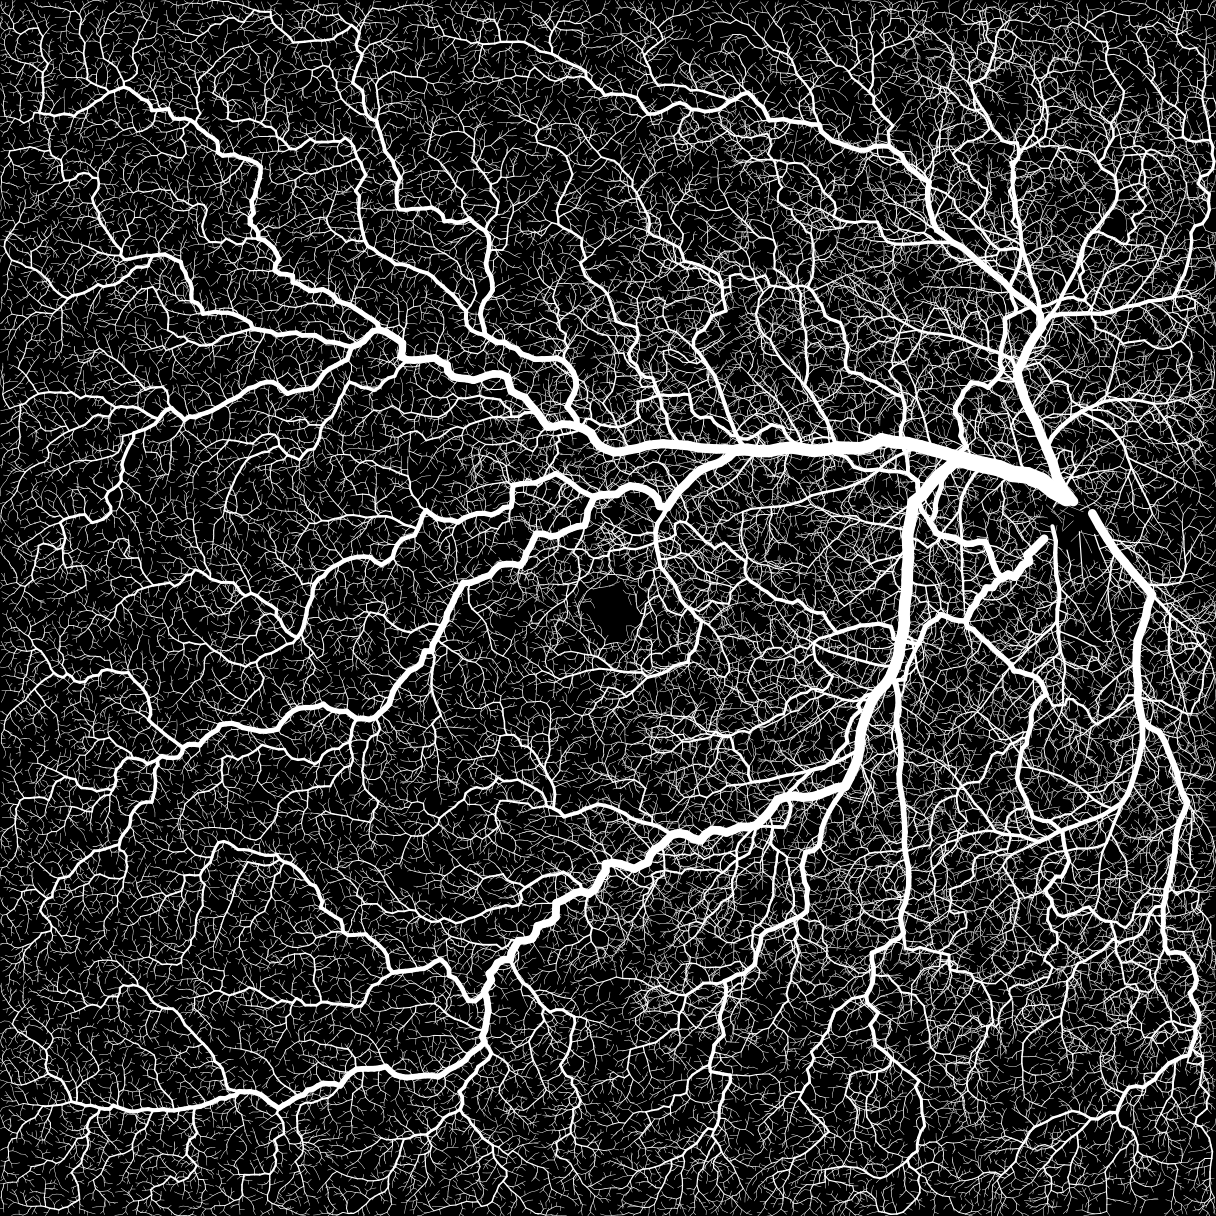

In [ ]:
image_paths = natsorted(glob(f'{config["output"]["directory"]}/**/art_ven_img_gray.png'))
image_path = image_paths[-1]
Image.open(image_path)

You can analyze the simulation by viewing the growth over time, and the time needed per time step.

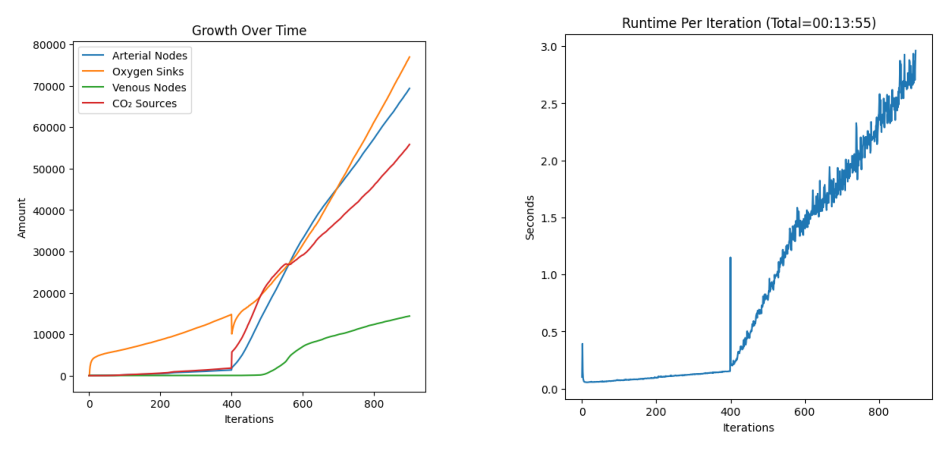

In [ ]:
_, (ax1,ax2) = plt.subplots(nrows=1,ncols=2, figsize=(12,6))
growth_over_time_path = image_path.replace("art_ven_img_gray.png", "growth_over_time.png")
time_per_step_path = image_path.replace("art_ven_img_gray.png", "time_per_step.png")
ax1.imshow(Image.open(growth_over_time_path))
ax1.set_axis_off()
ax2.imshow(Image.open(time_per_step_path))
ax2.set_axis_off()

# What's next?

Congratulations, you made it trough the example! 🎉

You can now start to optimize your configuration for realism and time.
To train a segmentation model using your new synthetic images, check out the notebook [example_train_gan-seg_with_new_dataset](./example_train_gan-seg_with_new_dataset.ipynb).